# 01-Data_Exploration

In [33]:
%%capture
# %pip install flwr[simulation] torch torchvision matplotlib sklearn openml

In [34]:
!pip install flwr[simulation] torch torchvision matplotlib scikit-learn openml

In [35]:
import os
import pandas as pd
import numpy as np
import flwr as fl
from tqdm import tqdm
import warnings
#warnings.filterwarnings('ignore')

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.common import Metrics
from torch.utils.data import DataLoader, random_split

In [36]:
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("torch", torch.__version__)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

flwr 1.20.0
numpy 2.0.2
torch 2.8.0+cu126
Training on cpu


In [37]:
### THIS SECTION NEEDS TO BE SET TO DETERMINE WHICH CONFIGURATION METHOD TO UTILISE

SPLIT_AVAILABLE_METHODS = ['STRATIFIED','LEAVE_ONE_OUT', 'ONE_CLASS', 'HALF_BENIGN' ]
METHOD = 'LEAVE_ONE_OUT'
NUM_OF_STRATIFIED_CLIENTS = 10  # only applies to stratified method
NUM_OF_ROUNDS = 5              # Number of FL rounds


In [38]:
individual_classifier = True
group_classifier = False
binary_classifier = False


In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# Load and combine all training data
import os
from tqdm import tqdm

# Define dataset directory (adjust path as needed)
DATASET_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/data/CICIoT2023/'

# Load all CSV files
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()

# Use 80% for training
training_sets = df_sets[:int(len(df_sets)*.8)]

print(f"Loading {len(training_sets)} training files...")

# First, let's check what columns are actually available in the dataset
sample_df = pd.read_csv(DATASET_DIRECTORY + training_sets[0])
print(f"Available columns in dataset: {list(sample_df.columns)}")
print(f"Dataset shape: {sample_df.shape}")

# Combine all training data with immediate rounding
combined_df = pd.DataFrame()
for file in tqdm(training_sets):
    df_temp = pd.read_csv(DATASET_DIRECTORY + file)

    # Round numbers immediately after loading each file
    print(f"Rounding numbers in {file}...")
    for col in df_temp.columns:
        if col != 'Label' and df_temp[col].dtype in ['float64', 'float32']:
            # Get max value to determine rounding precision
            col_max = df_temp[col].abs().max()

            if col_max > 1000:
                # Large values: round to 2 decimal places
                df_temp[col] = df_temp[col].round(2)
            elif col_max > 1:
                # Medium values: round to 4 decimal places
                df_temp[col] = df_temp[col].round(4)
            else:
                # Small values (0-1): round to 6 decimal places
                df_temp[col] = df_temp[col].round(6)

    combined_df = pd.concat([combined_df, df_temp], ignore_index=True)

print(f"Combined dataset shape: {combined_df.shape}")
print("All numbers have been rounded during loading process")

# Use actual column names from the dataset (excluding the Label column)
X_columns = [col for col in combined_df.columns if col != 'Label']
y_column = 'Label'

print(f"Using {len(X_columns)} feature columns")
print(f"Feature columns: {X_columns[:10]}...")  # Show first 10 columns

# Apply label mapping based on classification type
dict_34_classes = {
    'BENIGN': 0, 'DDOS-RSTFINFLOOD': 1, 'DDOS-PSHACK_FLOOD': 2, 'DDOS-SYN_FLOOD': 3,
    'DDOS-UDP_FLOOD': 4, 'DDOS-TCP_FLOOD': 5, 'DDOS-ICMP_FLOOD': 6, 'DDOS-SYNONYMOUSIP_FLOOD': 7,
    'DDOS-ACK_FRAGMENTATION': 8, 'DDOS-UDP_FRAGMENTATION': 9, 'DDOS-ICMP_FRAGMENTATION': 10,
    'DDOS-SLOWLORIS': 11, 'DDOS-HTTP_FLOOD': 12, 'DOS-UDP_FLOOD': 13, 'DOS-SYN_FLOOD': 14,
    'DOS-TCP_FLOOD': 15, 'DOS-HTTP_FLOOD': 16, 'MIRAI-GREETH_FLOOD': 17, 'MIRAI-GREIP_FLOOD': 18,
    'MIRAI-UDPPLAIN': 19, 'RECON-PINGSWEEP': 20, 'RECON-OSSCAN': 21, 'RECON-PORTSCAN': 22,
    'VULNERABILITYSCAN': 23, 'RECON-HOSTDISCOVERY': 24, 'DNS_SPOOFING': 25, 'MITM-ARPSPOOFING': 26,
    'BROWSERHIJACKING': 27, 'BACKDOOR_MALWARE': 28, 'XSS': 29, 'UPLOADING_ATTACK': 30,
    'SQLINJECTION': 31, 'COMMANDINJECTION': 32, 'DICTIONARYBRUTEFORCE': 33
}

dict_8_classes = {
    0: 0,  # Benign
    1:1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1,  # DDoS
    13: 7, 14: 7, 15: 7, 16: 7,  # DoS
    17: 2, 18: 2, 19: 2,  # Mirai
    20: 3, 21: 3, 22: 3, 23: 3, 24: 3,  # Reconnaissance
    25: 4, 26: 4,  # Spoofing
    27: 5, 28: 5, 29: 5, 30: 5, 31: 5, 32: 5,  # Web
    33: 6  # Brute Force
}

dict_2_classes = {
    0: 0,  # Benign
    1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1, 16:1,
    17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1,
    27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1  # All attacks as malicious
}

# Apply label mapping
combined_df['Label'] = combined_df['Label'].map(dict_34_classes)

if group_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_8_classes)
elif binary_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_2_classes)

# Remove rows with missing labels
combined_df = combined_df.dropna(subset=['Label'])
combined_df['Label'] = combined_df['Label'].astype(int)

print(f"Label distribution:\n{combined_df['Label'].value_counts().sort_index()}")


Loading 4 training files...
Available columns in dataset: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance', 'Label']
Dataset shape: (712311, 40)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
  0%|          | 0/4 [00:00<?, ?it/s]

Rounding numbers in Merged01.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 25%|██▌       | 1/4 [00:09<00:27,  9.00s/it]

Rounding numbers in Merged02.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 50%|█████     | 2/4 [00:18<00:19,  9.51s/it]

Rounding numbers in Merged03.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 75%|███████▌  | 3/4 [00:22<00:06,  6.76s/it]

Rounding numbers in Merged04.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 4/4 [00:25<00:00,  6.44s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Combined dataset shape: (2834805, 40)
All numbers have been rounded during loading process
Using 39 feature columns
Feature columns: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number']...
Label distribution:
Label
0      66396
1     244023
2     247295
3     245610
4     326263
5     270683
6     432865
7     217410
8      17330
9      17271
10     27248
11      1380
12      1766
13    199952
14    121972
15    160806
16      4426
17     59802
18     45003
19     53710
20       141
21      5795
22      4962
23     22623
24      8165
25     10938
26     18654
27       344
28       180
29       258
30        84
31       323
32       313
33       814
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Training data

In [41]:
# Check to see if the file 'training_data.pkl' exists in the directory. If it does, load it. If not, print an error.
if os.path.isfile('training_data.pkl'):
    print("File exists, loading data...")
    train_df = pd.read_pickle('training_data.pkl')
    print("Training data loaded from pickle file.")

else:
    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Training sets: {}'.format(len(training_sets)))
    print('Test sets: {}'.format(len(test_sets)))

    # ######################
    # # TEMP CODE - This would replicate the original authors code with the last CSV
    # # for training data. Uncomment this section to use this code.
    # ######################
    # # Set training_sets to the last entry of training_sets
    # training_sets = training_sets[-33:]
    # print(f"TO REPLICATE ORIGINAL AUTHORS CODE WITH ONE FILE TRAIN - {training_sets}")
    # #####################
    # # END TEMP CODE
    # ######################

    # Concatenate all training sets into one dataframe
    dfs = []
    print("Reading training data...")
    for train_set in tqdm(training_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + train_set)
        dfs.append(df_new)
    train_df = pd.concat(dfs, ignore_index=True)

    # Complete training data set size
    print("Complete training data size: {}".format(train_df.shape))

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    train_df['Label'] = train_df['Label'].map(dict_34_classes)

    # The training data is the 80% of the CSV files in the dataset. The test data is the remaining 20%.
    # The Ray Federated learning mechanism cannot cope with all of the 80% training data, so we will split
    # the training data using test_train_split. The test data will be ignored as we will use all the data
    # from the train_sets files as our training data to keep parity with the original authors code.
    #
    # By using a subset of the training data split this way, we can have a randomised selection of data
    # from all the training CSV files, stratified by the attack types.

    # Percentage of original training data to use.
    TRAIN_SIZE = 0.99

    print(f"Splitting the data into {TRAIN_SIZE*100}%")

    X_train, X_test, y_train, y_test = train_test_split(train_df[X_columns], train_df[y_column], test_size= (1 - TRAIN_SIZE), random_state=42, stratify=train_df[y_column])

    # Recombine X_train, and y_train into a dataframe
    train_df = pd.concat([X_train, y_train], axis=1)

    # Clean up unused variables

    del X_train, y_train, X_test, y_test

    # Save the output to a pickle file
    print("Writing training data to pickle file...")
    train_df.to_pickle('training_data.pkl')

print("Training data size: {}".format(train_df.shape))

File exists, loading data...
Training data loaded from pickle file.
Training data size: (2806456, 40)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [42]:
# show the unique values counts in the label column for train_df
print("Counts of attacks in train_df:")
print(train_df['Label'].value_counts())

Counts of attacks in train_df:
Label
6     428536
4     323000
5     267976
2     244822
3     243154
1     241583
7     215236
13    197952
15    159198
14    120752
0      65732
17     59204
19     53173
18     44553
10     26976
23     22397
26     18467
8      17157
9      17098
25     10829
24      8083
21      5737
22      4912
16      4382
12      1748
11      1366
33       806
27       341
31       320
32       310
29       255
28       178
20       140
30        83
Name: count, dtype: int64


In [43]:
train_df

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
106878,20.00,6,64.00,66313.106719,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000065,100,0.000000,7
1146355,20.00,6,64.00,26442.466272,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000038,100,0.000000,3
1166244,8.00,17,64.00,6952.614915,0.00,0.0,0.00,0.0,0.0,0.0,...,55400,554,554,554.00,0.000000,554.00,0.000160,100,0.000000,19
2670446,20.00,6,64.00,34433.166407,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000029,100,0.000000,3
380158,7.20,17,83.10,8807.492335,0.00,0.0,0.00,0.0,0.0,0.0,...,6100,60,70,61.00,3.015113,61.00,0.000114,100,9.090909,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443499,19.68,6,62.76,15858.081591,0.98,0.0,0.98,0.0,0.0,0.0,...,6303,60,363,63.03,30.300000,63.03,0.000064,100,918.090000,1
1029352,0.00,1,64.00,32564.472050,0.00,0.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000031,100,0.000000,6
323791,20.00,6,64.00,48663.464439,0.00,0.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000021,100,0.000000,5
354404,20.00,6,64.00,17346.170389,0.00,0.0,0.00,1.0,1.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000058,100,0.000000,2


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Test Data

In [44]:
# Check to see if the file 'test_data.pkl' exists in the directory. If it does, load it. If not, print an error.
testing_data_pickle_file = 'testing_data.pkl'

if os.path.isfile(testing_data_pickle_file):
    print(f"File {testing_data_pickle_file} exists, loading data...")
    test_df = pd.read_pickle(testing_data_pickle_file)
    print("Test data loaded from pickle file.")

else:
    print(f"File {testing_data_pickle_file} does not exist, constructing data...")

    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Test sets: {}'.format(len(test_sets)))

    # Concatenate all testing sets into one dataframe
    dfs = []
    print("Reading test data...")
    for test_set in tqdm(test_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + test_set)
        dfs.append(df_new)
    test_df = pd.concat(dfs, ignore_index=True)

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    test_df['Label'] = test_df['Label'].map(dict_34_classes)

    # Save the output to a pickle file
    print(f"Writing test data to pickle file {testing_data_pickle_file}...")
    test_df.to_pickle(testing_data_pickle_file)

print("Testing data size: {}".format(test_df.shape))

File testing_data.pkl exists, loading data...
Test data loaded from pickle file.
Testing data size: (744804, 40)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [45]:
print("Number of rows in train_df: {}".format(len(train_df)))
print("Number of rows in test_df: {}".format(len(test_df)))

train_size = len(train_df)
test_size = len(test_df)

Number of rows in train_df: 2806456
Number of rows in test_df: 744804



# Scale the test and train data


Scale the training data input features

In [46]:
scaler = StandardScaler()

# Check for and handle infinite values
print("Checking for and handling infinite values...")
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed.")

train_df[X_columns] = scaler.fit_transform(train_df[X_columns])

Checking for and handling infinite values...
Infinite values handled and rows with NaN removed.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [47]:
# Check for and handle infinite values
print("Checking for and handling infinite values in test data...")
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed from test data.")

# Fit the scaler on the training data and then transform the test data
#scaler.fit(train_df[X_columns])
test_df[X_columns] = scaler.transform(test_df[X_columns])

Checking for and handling infinite values in test data...
Infinite values handled and rows with NaN removed from test data.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [48]:
class_size_map = {2: "Binary", 8: "Group", 34: "Individual"}

if group_classifier:
    print("Group 8 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_7_classes values
    test_df['label'] = test_df['label'].map(dict_8_classes)
    train_df['label'] = train_df['label'].map(dict_8_classes)
    class_size = "8"

elif binary_classifier:
    print("Binary 2 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_2_classes values
    test_df['label'] = test_df['label'].map(dict_2_classes)
    train_df['label'] = train_df['label'].map(dict_2_classes)
    class_size = "2"

else:
    print ("Individual 34 Class classifier... - No adjustments to labels in test and train dataframes")
    class_size = "34"

Individual 34 Class classifier... - No adjustments to labels in test and train dataframes


# Split the Training Data into partitions for the Federated Learning clients depending on the test required

In [49]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the colours used for text printing
from enum import Enum
class Colours(Enum):
    RED = "\033[31m"
    YELLOW = "\033[33m"
    NORMAL = "\033[0m"

# Define fl_X_train and fl_y_train
fl_X_train = []
fl_y_train = []

client_df = pd.DataFrame()

# Define the target label column
y_column = 'Label'

# STRATIFIED method: evenly distribute class labels across clients
if METHOD == 'STRATIFIED':
    print(f"{Colours.YELLOW.value}STRATIFIED METHOD{Colours.NORMAL.value} with {class_size} class classifier")
    skf = StratifiedKFold(n_splits=NUM_OF_STRATIFIED_CLIENTS, shuffle=True, random_state=42)
    for _, test_index in skf.split(train_df[X_columns], train_df[y_column]):
        fl_X_train.append(train_df.iloc[test_index][X_columns])
        fl_y_train.append(train_df.iloc[test_index][y_column])

# LEAVE_ONE_OUT: remove one class (or benign) from each client’s dataset
elif METHOD == 'LEAVE_ONE_OUT':
    print(f"{Colours.YELLOW.value}LEAVE_ONE_OUT METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: exclude attack class 1
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Exclude one specific attack class
            client_df = current_fold_df[current_fold_df[y_column] != (i + 1)].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# ONE_CLASS: each client has Benign + 1 attack class only
elif METHOD == 'ONE_CLASS':
    print(f"{Colours.YELLOW.value}ONE_CLASS METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: only Benign data
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Include only Benign and the (i+1)-th attack class
            mask = (current_fold_df[y_column] == 0) | (current_fold_df[y_column] == (i + 1))
            client_df = current_fold_df[mask].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# HALF_BENIGN: alternate clients between only-benign and full-class datasets
elif METHOD == 'HALF_BENIGN':
    print(f"{Colours.YELLOW.value}HALF_BENIGN METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if i % 2 == 0:
            # Even-indexed clients: only Benign data
            client_df = current_fold_df[current_fold_df[y_column] == 0].copy()
        else:
            # Odd-indexed clients: all data
            client_df = current_fold_df.copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# Handle unknown METHOD value
else:
    print(f"{Colours.RED.value}ERROR: Method {METHOD} not recognised{Colours.NORMAL.value}")

# Update the number of clients created


LEAVE_ONE_OUT METHOD with 34 class classifier


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [50]:
# Model Poisoning Attack
print("--- Applying Model Poisoning ---")
num_malicious_clients = 11  # about 33% of 33 clients
malicious_client_ids = list(range(num_malicious_clients))
target_class = 6 # 'DDOS-ICMP_FLOOD' - This is the most frequent class
new_class = 0    # 'BENIGN'
poison_fraction = 1.0 # poison 100% of the target class samples in malicious clients

print(f"Poisoning {num_malicious_clients} clients: {malicious_client_ids}")
print(f"Flipping label from {target_class} to {new_class} for {poison_fraction*100}% of samples of malicious clients.")

for client_id in malicious_client_ids:
    # fl_y_train[client_id] is a pandas Series.
    # We can get the indices of the target class and replace the labels.
    y_train_series = fl_y_train[client_id]
    target_indices = y_train_series[y_train_series == target_class].index

    num_to_poison = int(len(target_indices) * poison_fraction)

    # Randomly select indices to poison
    poison_indices = np.random.choice(target_indices, num_to_poison, replace=False)

    # Flip the labels in the pandas Series
    fl_y_train[client_id].loc[poison_indices] = new_class

    print(f"Client {client_id}: Flipped {len(poison_indices)} labels from class {target_class} to {new_class}.")

print("--- Model Poisoning Applied ---")


--- Applying Model Poisoning ---
Poisoning 11 clients: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Flipping label from 6 to 0 for 100.0% of samples of malicious clients.
Client 0: Flipped 12985 labels from class 6 to 0.
Client 1: Flipped 12985 labels from class 6 to 0.
Client 2: Flipped 12985 labels from class 6 to 0.
Client 3: Flipped 12986 labels from class 6 to 0.
Client 4: Flipped 12986 labels from class 6 to 0.
Client 5: Flipped 0 labels from class 6 to 0.
Client 6: Flipped 12986 labels from class 6 to 0.
Client 7: Flipped 12986 labels from class 6 to 0.
Client 8: Flipped 12986 labels from class 6 to 0.
Client 9: Flipped 12986 labels from class 6 to 0.
Client 10: Flipped 12986 labels from class 6 to 0.
--- Model Poisoning Applied ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [51]:
# Update the number of clients created
NUM_OF_CLIENTS = len(fl_X_train)
# --- Inspect the training data for each client ---
for i in range(NUM_OF_CLIENTS):
    print(f"\n--- Client ID: {i} ---")
    print(f"fl_X_train[{i}].shape: {fl_X_train[i].shape}")
    print(f"fl_y_train[{i}].value_counts():\n{fl_y_train[i].value_counts()}")
    print(f"fl_y_train[{i}].unique(): {fl_y_train[i].unique()}")

# Check if two clients have identical feature data
print(f"\nfl_X_train[0].equals(fl_X_train[1]): {fl_X_train[0].equals(fl_X_train[1])}")


--- Client ID: 0 ---
fl_X_train[0].shape: (77723, 39)
fl_y_train[0].value_counts():
Label
0     14977
4      9788
5      8121
2      7419
3      7368
7      6523
13     5998
15     4825
14     3659
17     1794
19     1611
18     1350
10      818
23      678
26      560
8       519
9       518
25      328
24      245
21      174
22      148
16      133
12       53
11       41
33       25
27       11
31        9
32        9
29        8
20        5
28        5
30        3
Name: count, dtype: int64
fl_y_train[0].unique(): [ 4  0 13 18 25 19 24  2  5  7 14 15  3 17 10 23 11  8 33 26 22 12 21  9
 16 27 30 29 28 20 31 32]

--- Client ID: 1 ---
fl_X_train[1].shape: (77624, 39)
fl_y_train[1].value_counts():
Label
0     14977
4      9788
5      8121
3      7368
1      7320
7      6523
13     5998
15     4825
14     3659
17     1794
19     1611
18     1350
10      818
23      678
26      560
8       519
9       518
25      328
24      245
21      174
22      148
16      133
12       53
11       

Visualize Data Distribution

STRATIFIED Client

In [52]:
#STRATIFIED Client

In [53]:
#LEAVE_ONE_OUT

In [54]:
#Half begign

In [55]:
#One class

/tmp/ipython-input-3333892375.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors1 = plt.cm.get_cmap('tab20', 20)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


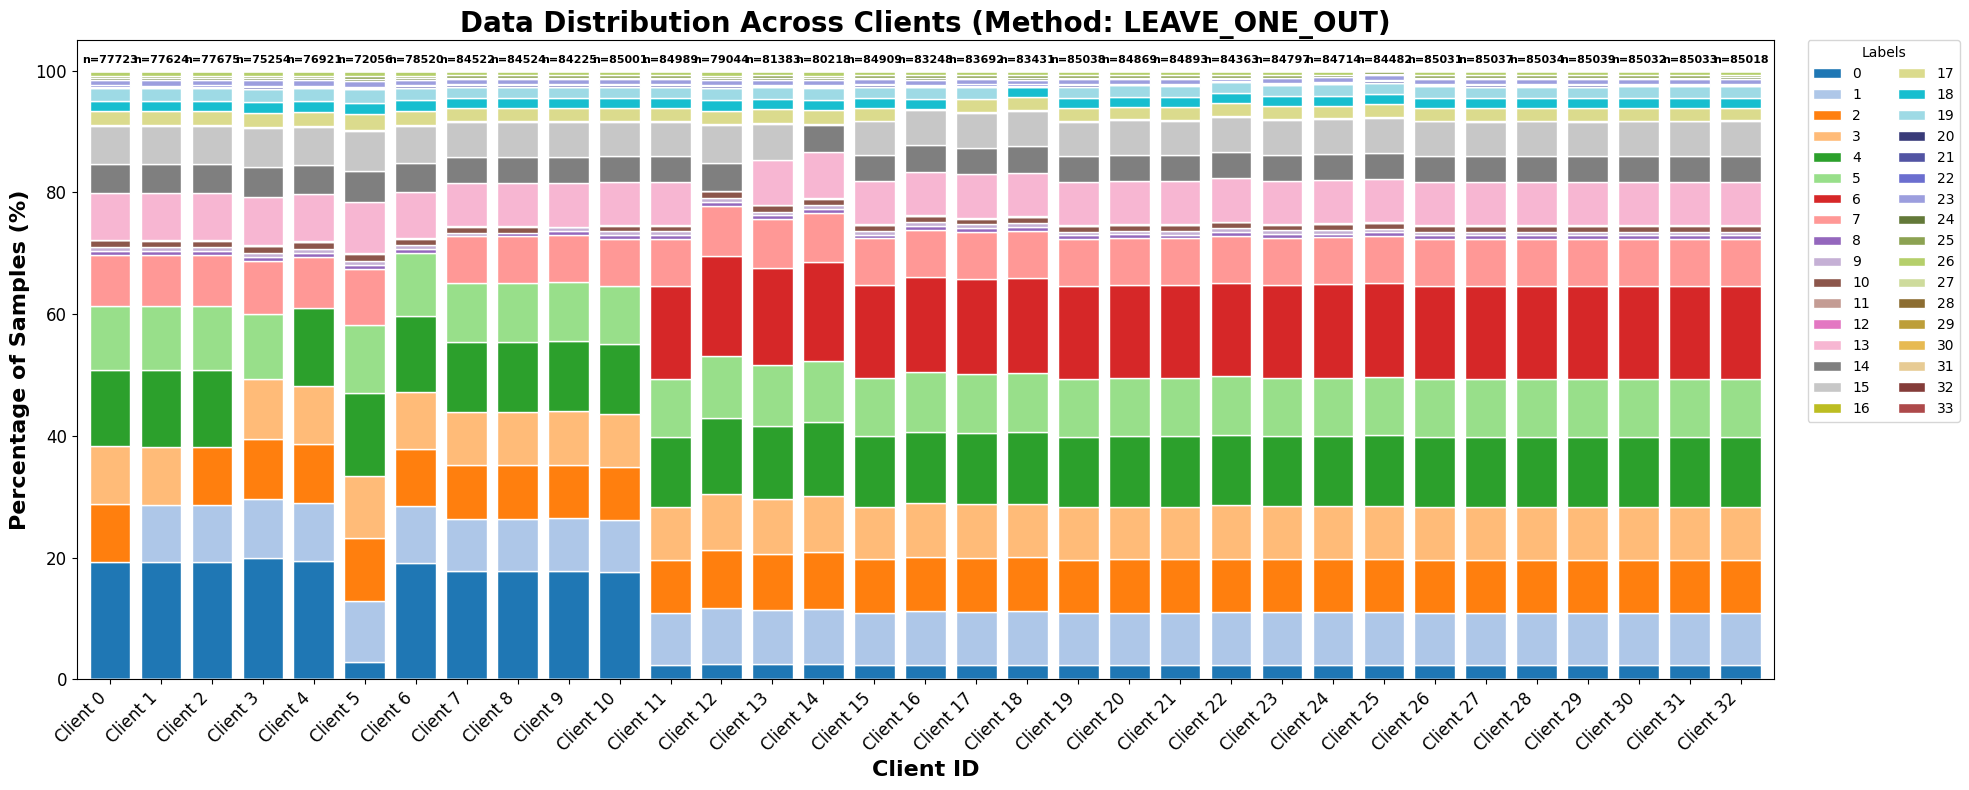

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [56]:
client_distributions = {}
for i in range(NUM_OF_CLIENTS):
    # .value_counts() returns a Series, convert it to a dictionary
    client_distributions[f'Client {i}'] = fl_y_train[i].value_counts().to_dict()

# 2. Convert the dictionary to a Pandas DataFrame for easy manipulation
df_dist = pd.DataFrame(client_distributions).fillna(0).astype(int)
df_dist = df_dist.sort_index() # Sort the labels numerically for consistent colors

# 3. Plot a Stacked Bar Chart
# Convert absolute counts to percentages for the chart y-axis
df_percent = df_dist.divide(df_dist.sum(axis=0), axis=1) * 100

# Create a diverse color palette to ensure distinct colors for all 34 labels
# We combine multiple colormaps to get enough unique colors
colors1 = plt.cm.get_cmap('tab20', 20)
colors2 = plt.cm.get_cmap('tab20b', 20)
colors = np.vstack((colors1.colors, colors2.colors))

# Plot the chart with a much wider figure size
ax = df_percent.T.plot(
    kind='bar',
    stacked=True,
    figsize=(22, 8), # Increased width for readability
    color=colors,
    width=0.8,
    edgecolor="white"
)

# 4. Customize the plot for better presentation
plt.title(f'Data Distribution Across Clients (Method: {METHOD})', fontsize=20, fontweight='bold')
plt.xlabel('Client ID', fontsize=16, fontweight='bold')
plt.ylabel('Percentage of Samples (%)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12) # Rotate labels for better fit
plt.yticks(fontsize=12)
plt.ylim(0, 105) # Add a little space at the top for annotations

# Move the legend outside the plot and arrange it in 2 columns
plt.legend(
    title='Labels',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize='medium',
    ncol=2 # Arrange legend in two columns
)

# Adjust layout to prevent the legend from being cut off
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Add total sample count (n=...) above each bar for context
for i, total in enumerate(df_dist.sum(axis=0)):
    ax.text(i, 101, f'n={total}', ha='center', va='bottom', fontsize=8, fontweight='bold')

#  plt.show()

Prepare an output directory where we can store the results of the federated learning

In [57]:
# Create an "Output" directory if it doesnt exist already
if not os.path.exists("Output"):
    os.makedirs("Output")

sub_dir_name = f"train_size-{train_size}"

# if sub_dir_name does not exist, create it
if not os.path.exists(f"Output/{sub_dir_name}"):
    os.makedirs(f"Output/{sub_dir_name}")

test_directory_name = f"{METHOD}_Classifier-{class_size}_Clients-{NUM_OF_CLIENTS}"
output_path = f"Output/{sub_dir_name}/{test_directory_name}" # Lưu lại đường dẫn để dùng sau

# Create an "Output/{METHOD}-{NUM_OF_CLIENTS}-{NUM_OF_ROUNDS}" directory if it doesnt exist already
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Ensure the directory is empty
for file in os.listdir(output_path):
    file_path = os.path.join(output_path, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)

# Original training size is the sum of all the fl_X_train sizes
original_training_size = 0
for i in range(len(fl_X_train)):
    original_training_size += fl_X_train[i].shape[0]

# Write this same info to the output directory/Class Split Info.txt
with open(f"{output_path}/Class Split Info.txt", "w") as f:
    for i in range(len(fl_X_train)):
        f.write(f"Client ID: {i}\n")
        f.write(f"fl_X_train.shape: {fl_X_train[i].shape}\n")
        f.write(f"Training data used {original_training_size}\n")
        f.write(f"fl_y_train.value_counts():\n{fl_y_train[i].value_counts().to_string()}\n")
        f.write(f"fl_y_train.unique(): {fl_y_train[i].unique()}\n\n")

print(f"Output directory and summary file created at: {output_path}")

Output directory and summary file created at: Output/train_size-2806456/LEAVE_ONE_OUT_Classifier-34_Clients-33


Convert the training dataset


In [58]:
# Convert the testing dataframe to numpy arrays for TensorFlow/Keras
X_test = test_df[X_columns].to_numpy()
y_test = test_df[y_column].to_numpy()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [59]:
# Determine the number of unique classes in the target column
num_unique_classes = len(train_df[y_column].unique())

# Store the shapes of the original dataframes for logging purposes before deleting them
train_df_shape = train_df.shape
test_df_shape = test_df.shape

# Now that we have fl_X_train, fl_y_train, X_test, and y_test extracted,
# we can safely delete the large dataframes to free up memory
if 'train_df' in locals():
    del train_df
if 'test_df' in locals():
    del test_df
if 'client_df' in locals():
    del client_df
print("Final data conversion to numpy complete. Dataframes deleted to free up memory.")

Final data conversion to numpy complete. Dataframes deleted to free up memory.


Data check

In [60]:
print("NUM_CLIENTS:", NUM_OF_CLIENTS)

print("NUM_ROUNDS:", NUM_OF_ROUNDS)
print()


print("Original training size: {}".format(original_training_size))


print("Checking training data split groups")
for i in range(len(fl_X_train)):
    print(i, ":", "X Shape", fl_X_train[i].shape, "Y Shape", fl_y_train[i].shape)


# Print the sizes of X_test and y_test
print("\nChecking testing data")
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

print("\nDeploy Simulation")

NUM_CLIENTS: 33
NUM_ROUNDS: 5

Original training size: 2723339
Checking training data split groups
0 : X Shape (77723, 39) Y Shape (77723,)
1 : X Shape (77624, 39) Y Shape (77624,)
2 : X Shape (77675, 39) Y Shape (77675,)
3 : X Shape (75254, 39) Y Shape (75254,)
4 : X Shape (76921, 39) Y Shape (76921,)
5 : X Shape (72056, 39) Y Shape (72056,)
6 : X Shape (78520, 39) Y Shape (78520,)
7 : X Shape (84522, 39) Y Shape (84522,)
8 : X Shape (84524, 39) Y Shape (84524,)
9 : X Shape (84225, 39) Y Shape (84225,)
10 : X Shape (85001, 39) Y Shape (85001,)
11 : X Shape (84989, 39) Y Shape (84989,)
12 : X Shape (79044, 39) Y Shape (79044,)
13 : X Shape (81383, 39) Y Shape (81383,)
14 : X Shape (80218, 39) Y Shape (80218,)
15 : X Shape (84909, 39) Y Shape (84909,)
16 : X Shape (83248, 39) Y Shape (83248,)
17 : X Shape (83692, 39) Y Shape (83692,)
18 : X Shape (83431, 39) Y Shape (83431,)
19 : X Shape (85038, 39) Y Shape (85038,)
20 : X Shape (84869, 39) Y Shape (84869,)
21 : X Shape (84893, 39) Y Sh

In [61]:
print("X_test min/max/mean:", np.min(X_test), np.max(X_test), np.mean(X_test))
print("Client 0 X min/max/mean:", np.min(fl_X_train[0]), np.max(fl_X_train[0]), np.mean(fl_X_train[0]))

X_test min/max/mean: -52.92539879493338 476.80242930958366 -0.000634890663062242
Client 0 X min/max/mean: -52.92539879493338 136.22155747982657 -0.02330975502083858


#Federated Learning

Import the libraries and print the versions


In [62]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout


Define the Client and Server code

In [63]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

print('scikit-learn {}.'.format(sklearn.__version__))
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("tf", tf.__version__)
# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

import datetime

client_evaluations = []

class NumpyFlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, model, train_data, train_labels):
        self.model = model
        self.cid = cid
        self.train_data = train_data
        self.train_labels = train_labels

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Training...")
        self.model.fit(self.train_data, self.train_labels, epochs=1, batch_size=32)
        print ("Client ", self.cid, "Training complete...")
        return self.model.get_weights(), len(self.train_data), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Evaluating...")
        loss, accuracy = self.model.evaluate(self.train_data, self.train_labels, batch_size=32)
        print(f"{Colours.YELLOW.value}Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}{Colours.NORMAL.value}")

        # Write the same message to the "Output/{cid}_Evaluation.txt" file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/{self.cid}_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}\n")

            # Close the file
            f.close()

        return loss, len(self.train_data), {"accuracy": accuracy}

    def predict(self, incoming):
        prediction = np.argmax( self.model.predict(incoming) ,axis=1)
        return prediction

def client_fn(cid: str) -> NumpyFlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    #model = tf.keras.applications.MobileNetV2((32, 32, 3), classes=10, weights=None)
    #model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

    print ("Client ID:", cid)

    model = Sequential([
      #Flatten(input_shape=(79,1)),
      Dense(50, activation='relu', input_shape=(fl_X_train[0].shape[1],)),
      Dense(25, activation='relu'),
      Dense(num_unique_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    partition_id = int(cid)
    X_train_c = fl_X_train[partition_id]
    y_train_c = fl_y_train[partition_id]

    # Create a  single Flower client representing a single organization
    return NumpyFlowerClient(cid, model, X_train_c, y_train_c)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
eval_count = 0

def get_evaluate_fn(server_model):
    global eval_count

    def evaluate(server_round, parameters, config):
        global eval_count

        # Update model weights from the latest client parameters
        server_model.set_weights(parameters)
        print(f"Server Evaluating... Evaluation Count: {eval_count}")

        # Evaluate the model on the test set
        loss, accuracy = server_model.evaluate(X_test, y_test)

        # Record accuracy and loss for visualization or tracking
        server_accuracy_history.append(accuracy)
        server_loss_history.append(loss)

        # Make predictions and save them to a file
        y_pred = server_model.predict(X_test)
        print("Prediction: ", y_pred, y_pred.shape)
        np.save("y_pred-" + str(eval_count) + ".npy", y_pred)

        # Print evaluation result to console
        print(f"{Colours.YELLOW.value}Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}{Colours.NORMAL.value}")

        # Write evaluation log to file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/Server_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - {server_round} : Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}\n")

        # Increment evaluation counter
        eval_count += 1

        return loss, {"accuracy": accuracy}

    return evaluate



scikit-learn 1.6.1.
flwr 1.20.0
numpy 2.0.2
tf 2.19.0


Initialize Server Model and Strategy

In [64]:
from flwr.server.strategy import FedProx

from flwr.common import ndarrays_to_parameters
server_model = Sequential([
    #Flatten(input_shape=(79,1)),
    Flatten(input_shape=(fl_X_train[0].shape[1] , 1)),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(num_unique_classes, activation='softmax')
])


server_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

initial_weights = server_model.get_weights()
initial_parameters = ndarrays_to_parameters(initial_weights)


# Define FedProx strategy
strategy = FedProx(
    proximal_mu=1.0,  # Proximal term coefficient (tune as needed)
    fraction_fit=1.0,  # Fraction of clients to sample for training
    fraction_evaluate=1.0,  # Fraction of clients to sample for evaluation
    min_fit_clients=NUM_OF_CLIENTS,  # Minimum number of clients for training
    min_evaluate_clients=NUM_OF_CLIENTS,  # Minimum number of clients for evaluation
    min_available_clients=NUM_OF_CLIENTS,  # Minimum number of available clients
    evaluate_fn=get_evaluate_fn(server_model),
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Deploy Simulation

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout



Deploy simulation... Method = LEAVE_ONE_OUT - Individual (34) Classifier
Number of Clients = 33

Writing output to: train_size-2806456/LEAVE_ONE_OUT_Classifier-34_Clients-33



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2025-09-04 11:57:37,849	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7987964315.0, 'object_store_memory': 3993982156.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=2977) WARNING: All log messages before absl::InitializeLog() 

(ClientAppActor pid=2978) Client ID: 32
Server Evaluating... Evaluation Count: 0
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - accuracy: 0.0084 - loss: 3.7655
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step
Prediction:  [[0.0413319  0.02055698 0.03648969 ... 0.02702613 0.02861045 0.03887458]
 [0.02498031 0.02370758 0.02850591 ... 0.02448734 0.01920249 0.03271217]
 [0.0336929  0.02255688 0.03151886 ... 0.03298358 0.03326057 0.03156703]
 ...
 [0.04512829 0.01057832 0.06488446 ... 0.02224102 0.02021614 0.03779423]
 [0.03317607 0.02395911 0.02858121 ... 0.02895967 0.02671944 0.0326627 ]
 [0.03369412 0.02455747 0.02893348 ... 0.02970754 0.02600018 0.03150441]] (744790, 34)


INFO :      initial parameters (loss, other metrics): 3.7659053802490234, {'accuracy': 0.008301668800413609}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


Server evaluation complete - Accuracy: 0.0083, Loss: 3.7659


(ClientAppActor pid=2978) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2978) 
(ClientAppActor pid=2978)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2978)             entirely in future versions of Flower.
(ClientAppActor pid=2978)         
(ClientAppActor pid=2978) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2978)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=2978) Client ID: 27


(ClientAppActor pid=2978) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2978) Client  27 Training...
(ClientAppActor pid=2977) Client ID: 13


(ClientAppActor pid=2977) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2977) 
(ClientAppActor pid=2977)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2977)             entirely in future versions of Flower.
(ClientAppActor pid=2977)         


   1/2658 ━━━━━━━━━━━━━━━━━━━━ 1:21:20 2s/step - accuracy: 0.0000e+00 - loss: 3.8960
  25/2658 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.0781 - loss: 3.6322
  59/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.2098 - loss: 3.4128
  95/2658 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.2939 - loss: 3.1746
 448/2544 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5494 - loss: 1.8390
 768/2544 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6114 - loss: 1.4559
(ClientAppActor pid=2977) Client  13 Training...
   1/2544 ━━━━━━━━━━━━━━━━━━━━ 1:10:17 2s/step - accuracy: 0.0000e+00 - loss: 3.8134
  29/2544 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.1060 - loss: 3.5506 
1168/2544 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6490 - loss: 1.2142 [repeated 92x across cluster]
1323/2658 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6263 - loss: 1.2435
1330/2658 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6267 - loss: 1.2409 [repeated 6x across cluster]
2162/2544 ━━━━━━━━━━━━━━━━━

(ClientAppActor pid=2977) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2977) 
(ClientAppActor pid=2977)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2977)             entirely in future versions of Flower.
(ClientAppActor pid=2977)         
(ClientAppActor pid=2977) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2977)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2977) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2977) Client ID: 1
2654/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6694 - loss: 0.9632 [repeated 23x across cluster]
2544/2544 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.6986 - loss: 0.8893
(ClientAppActor pid=2977) Client  13 Training complete...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

Server Evaluating... Evaluation Count: 1
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 203s 2ms/step - accuracy: 0.7383 - loss: 0.7716
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step
Prediction:  [[3.7498703e-05 4.7369587e-05 5.8653914e-08 ... 1.0649617e-05
  1.2349701e-06 1.9447485e-05]
 [3.7317541e-06 4.6791870e-06 9.9916810e-01 ... 4.9120388e-08
  4.2365772e-07 4.9663521e-07]
 [1.8861522e-06 2.1678122e-07 2.2670961e-06 ... 1.9270923e-05
  2.3345630e-07 2.0407981e-06]
 ...
 [5.0557053e-05 6.7188736e-08 2.3877772e-05 ... 2.9357304e-07
  1.2736498e-07 1.0254053e-05]
 [1.0112968e-05 8.8631696e-06 2.0721997e-04 ... 1.8453353e-06
  4.4773769e-06 5.9385566e-06]
 [1.9867626e-05 9.5082942e-06 3.4895650e-04 ... 3.3184817e-06
  6.5629915e-06 9.6267995e-06]] (744790, 34)


INFO :      fit progress: (1, 0.7710522413253784, {'accuracy': 0.7384846806526184}, 775.39648173)
INFO :      configure_evaluate: strategy sampled 33 clients (out of 33)


Server evaluation complete - Accuracy: 0.7385, Loss: 0.7711


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

Server Evaluating... Evaluation Count: 2
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 0.7383 - loss: 0.7716
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step
Prediction:  [[3.7498703e-05 4.7369587e-05 5.8653914e-08 ... 1.0649617e-05
  1.2349701e-06 1.9447485e-05]
 [3.7317541e-06 4.6791870e-06 9.9916810e-01 ... 4.9120388e-08
  4.2365772e-07 4.9663521e-07]
 [1.8861522e-06 2.1678122e-07 2.2670961e-06 ... 1.9270923e-05
  2.3345630e-07 2.0407981e-06]
 ...
 [5.0557053e-05 6.7188736e-08 2.3877772e-05 ... 2.9357304e-07
  1.2736498e-07 1.0254053e-05]
 [1.0112968e-05 8.8631696e-06 2.0721997e-04 ... 1.8453353e-06
  4.4773769e-06 5.9385566e-06]
 [1.9867626e-05 9.5082942e-06 3.4895650e-04 ... 3.3184817e-06
  6.5629915e-06 9.6267995e-06]] (744790, 34)


INFO :      fit progress: (2, 0.7710522413253784, {'accuracy': 0.7384846806526184}, 961.3143005009999)
INFO :      configure_evaluate: strategy sampled 33 clients (out of 33)


Server evaluation complete - Accuracy: 0.7385, Loss: 0.7711


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

Server Evaluating... Evaluation Count: 3
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.7383 - loss: 0.7716
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step
Prediction:  [[3.7498703e-05 4.7369587e-05 5.8653914e-08 ... 1.0649617e-05
  1.2349701e-06 1.9447485e-05]
 [3.7317541e-06 4.6791870e-06 9.9916810e-01 ... 4.9120388e-08
  4.2365772e-07 4.9663521e-07]
 [1.8861522e-06 2.1678122e-07 2.2670961e-06 ... 1.9270923e-05
  2.3345630e-07 2.0407981e-06]
 ...
 [5.0557053e-05 6.7188736e-08 2.3877772e-05 ... 2.9357304e-07
  1.2736498e-07 1.0254053e-05]
 [1.0112968e-05 8.8631696e-06 2.0721997e-04 ... 1.8453353e-06
  4.4773769e-06 5.9385566e-06]
 [1.9867626e-05 9.5082942e-06 3.4895650e-04 ... 3.3184817e-06
  6.5629915e-06 9.6267995e-06]] (744790, 34)


INFO :      fit progress: (3, 0.7710522413253784, {'accuracy': 0.7384846806526184}, 1146.988079988)
INFO :      configure_evaluate: strategy sampled 33 clients (out of 33)


Server evaluation complete - Accuracy: 0.7385, Loss: 0.7711


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

Server Evaluating... Evaluation Count: 4
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 75s 3ms/step - accuracy: 0.7383 - loss: 0.7716
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step
Prediction:  [[3.7498703e-05 4.7369587e-05 5.8653914e-08 ... 1.0649617e-05
  1.2349701e-06 1.9447485e-05]
 [3.7317541e-06 4.6791870e-06 9.9916810e-01 ... 4.9120388e-08
  4.2365772e-07 4.9663521e-07]
 [1.8861522e-06 2.1678122e-07 2.2670961e-06 ... 1.9270923e-05
  2.3345630e-07 2.0407981e-06]
 ...
 [5.0557053e-05 6.7188736e-08 2.3877772e-05 ... 2.9357304e-07
  1.2736498e-07 1.0254053e-05]
 [1.0112968e-05 8.8631696e-06 2.0721997e-04 ... 1.8453353e-06
  4.4773769e-06 5.9385566e-06]
 [1.9867626e-05 9.5082942e-06 3.4895650e-04 ... 3.3184817e-06
  6.5629915e-06 9.6267995e-06]] (744790, 34)


INFO :      fit progress: (4, 0.7710522413253784, {'accuracy': 0.7384846806526184}, 1332.058578315)
INFO :      configure_evaluate: strategy sampled 33 clients (out of 33)


Server evaluation complete - Accuracy: 0.7385, Loss: 0.7711


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

Server Evaluating... Evaluation Count: 5
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 90s 4ms/step - accuracy: 0.7383 - loss: 0.7716
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step
Prediction:  [[3.7498703e-05 4.7369587e-05 5.8653914e-08 ... 1.0649617e-05
  1.2349701e-06 1.9447485e-05]
 [3.7317541e-06 4.6791870e-06 9.9916810e-01 ... 4.9120388e-08
  4.2365772e-07 4.9663521e-07]
 [1.8861522e-06 2.1678122e-07 2.2670961e-06 ... 1.9270923e-05
  2.3345630e-07 2.0407981e-06]
 ...
 [5.0557053e-05 6.7188736e-08 2.3877772e-05 ... 2.9357304e-07
  1.2736498e-07 1.0254053e-05]
 [1.0112968e-05 8.8631696e-06 2.0721997e-04 ... 1.8453353e-06
  4.4773769e-06 5.9385566e-06]
 [1.9867626e-05 9.5082942e-06 3.4895650e-04 ... 3.3184817e-06
  6.5629915e-06 9.6267995e-06]] (744790, 34)


INFO :      fit progress: (5, 0.7710522413253784, {'accuracy': 0.7384846806526184}, 1526.0734293260002)
INFO :      configure_evaluate: strategy sampled 33 clients (out of 33)


Server evaluation complete - Accuracy: 0.7385, Loss: 0.7711


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

Total time taken:  0:27:36.443386
SIMULATION COMPLETE. Method = LEAVE_ONE_OUT - Individual (34) Classifier
Number of Clients = 33



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


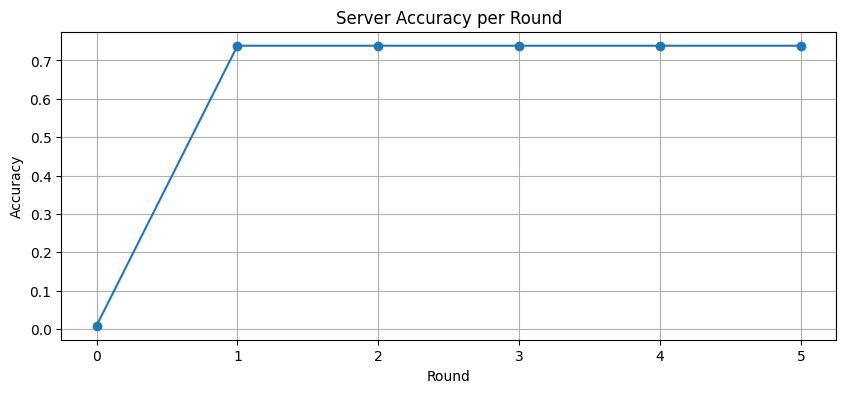

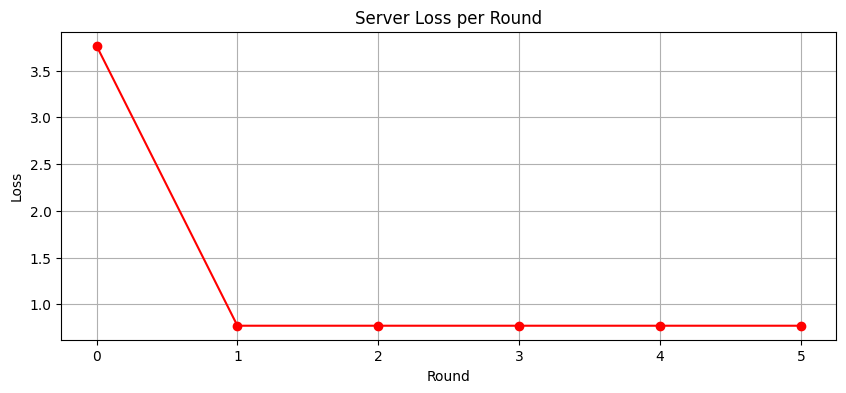

In [65]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# --- LOG START ---
print(f"{Colours.YELLOW.value}\nDeploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}\n")
print(f"Writing output to: {sub_dir_name}/{test_directory_name}\n{Colours.NORMAL.value}")

# Ghi thông tin ban đầu vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - Deploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Number of Clients = {NUM_OF_CLIENTS}\n")
    f.write(f"{datetime.datetime.now()} - Original train_df size: {train_df_shape}\n")

    for i in range(len(fl_X_train)):
        f.write(f"{datetime.datetime.now()} - {i}: X Shape {fl_X_train[i].shape}, Y Shape {fl_y_train[i].shape}\n")

    f.write(f"{datetime.datetime.now()} - X_test size: {X_test.shape}\n")
    f.write(f"{datetime.datetime.now()} - y_test size: {y_test.shape}\n")

# --- START SIMULATION ---
start_time = datetime.datetime.now()

ray_init_args = {"num_cpus": 2}

server_accuracy_history = []
server_loss_history = []

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_OF_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_OF_ROUNDS),
    strategy=strategy,
    client_resources={"num_cpus": 1},
    ray_init_args=ray_init_args,
)

end_time = datetime.datetime.now()
print("Total time taken: ", end_time - start_time)

# --- LOG END ---
print(f"{Colours.YELLOW.value}SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}{Colours.NORMAL.value}\n")

# Ghi thông tin kết thúc vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Total time taken: {end_time - start_time}\n")

# --- PLOT ACCURACY ---
plt.figure(figsize=(10, 4))
plt.plot(server_accuracy_history, marker='o')
plt.title('Server Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_accuracy_per_round.png")
plt.show()

# --- PLOT LOSS ---
plt.figure(figsize=(10, 4))
plt.plot(server_loss_history, marker='o', color='red')
plt.title('Server Loss per Round')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_loss_per_round.png")
plt.show()
